In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # For progress bars in Jupyter
import time
import math

# Set visual styling for plots
plt.style.use("seaborn-whitegrid")
sns.set(style="whitegrid", font_scale=1.2)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

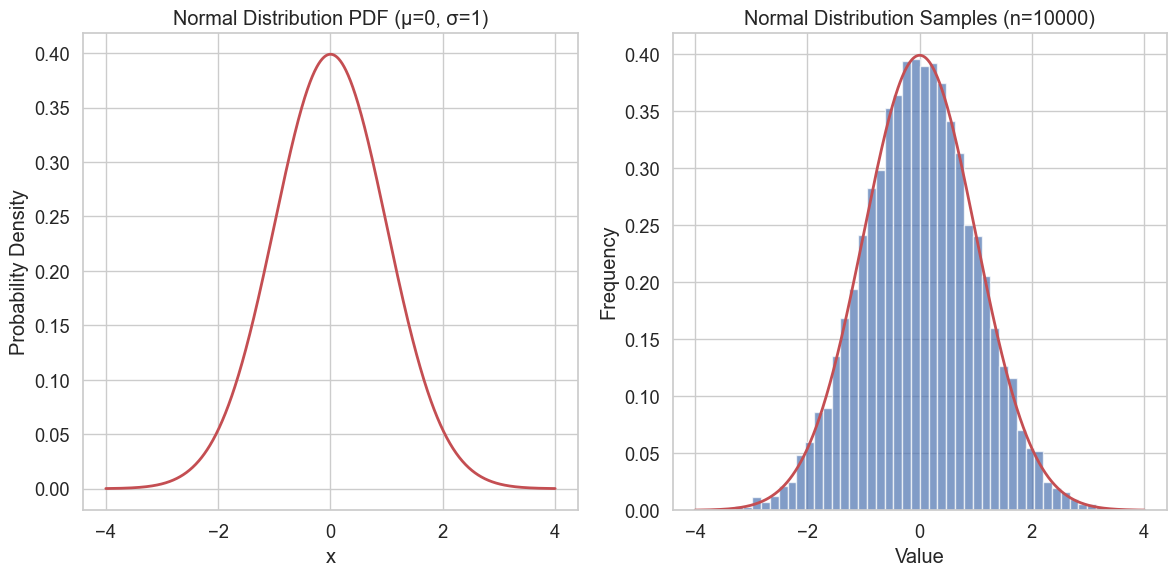

In [2]:
def plot_normal_distribution(mean=0, std=1, samples=10000):
    """Plot the PDF and histogram of a normal distribution."""
    x = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
    pdf = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-((x - mean) ** 2) / (2 * std**2))

    # Generate random samples from this distribution
    samples = np.random.normal(mean, std, samples)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(x, pdf, "r-", lw=2)
    plt.title(f"Normal Distribution PDF (μ={mean}, σ={std})")
    plt.xlabel("x")
    plt.ylabel("Probability Density")

    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=50, density=True, alpha=0.7)
    plt.plot(x, pdf, "r-", lw=2)
    plt.title(f"Normal Distribution Samples (n={len(samples)})")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# Visualize the target normal distribution
plot_normal_distribution(mean=0, std=1)

In [3]:
# Parameters
batch_size = 512  # Number of samples per batch
z_dim = 2  # Dimension of noise vector (latent space)
target_mean = 0  # Target mean of the normal distribution
target_std = 1  # Target standard deviation
lr = 0.0002  # Learning rate for Adam optimizer
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer
beta2 = 0.999  # Beta2 hyperparameter for Adam optimizer
num_epochs = 5000  # Total training epochs
display_step = 500  # How often to display results
hidden_size = [16, 32, 16]  # Sizes of hidden layers

# Advanced parameters (explained later)
label_smoothing = 0.1  # Label smoothing factor to help stabilize training

# Device configuration - will use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dims=[16, 32, 16]):
        """
        Generator network that transforms noise to samples.

        Args:
            z_dim (int): Dimension of input noise vector
            hidden_dims (list): Dimensions of hidden layers
        """
        super(Generator, self).__init__()

        # Build layers dynamically based on hidden_dims
        layers = []
        input_dim = z_dim

        # Add hidden layers
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.LeakyReLU(0.2))
            input_dim = h_dim

        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], 1))

        # Create sequential model
        self.gen = nn.Sequential(*layers)

    def forward(self, z):
        """
        Forward pass of the generator.

        Args:
            z (Tensor): Input noise, shape [batch_size, z_dim]

        Returns:
            Tensor: Generated samples, shape [batch_size, 1]
        """
        return self.gen(z)

    def generate_samples(self, num_samples=1000):
        """
        Generate samples from the generator.

        Args:
            num_samples (int): Number of samples to generate

        Returns:
            numpy array: Generated samples
        """
        # Generate random noise
        with torch.no_grad():
            z = torch.randn(num_samples, z_dim).to(device)
            samples = self.forward(z).cpu().numpy()
        return samples


# Initialize the generator
generator = Generator(z_dim, hidden_size).to(device)

# Print model architecture
print("Generator Architecture:")
print(generator)
print(f"Number of parameters: {sum(p.numel() for p in generator.parameters())}")

# Analyze a single forward pass with a small batch
test_noise = torch.randn(5, z_dim)
test_output = generator(test_noise)
print(f"\nTest noise shape: {test_noise.shape}")
print(f"Test output shape: {test_output.shape}")
print(f"Sample generator outputs: {test_output.flatten().tolist()}")

Generator Architecture:
Generator(
  (gen): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)
Number of parameters: 1137

Test noise shape: torch.Size([5, 2])
Test output shape: torch.Size([5, 1])
Sample generator outputs: [-0.05316825211048126, -0.09896176308393478, -0.014496207237243652, -0.028114549815654755, 0.01896781474351883]


Generator output BEFORE training:


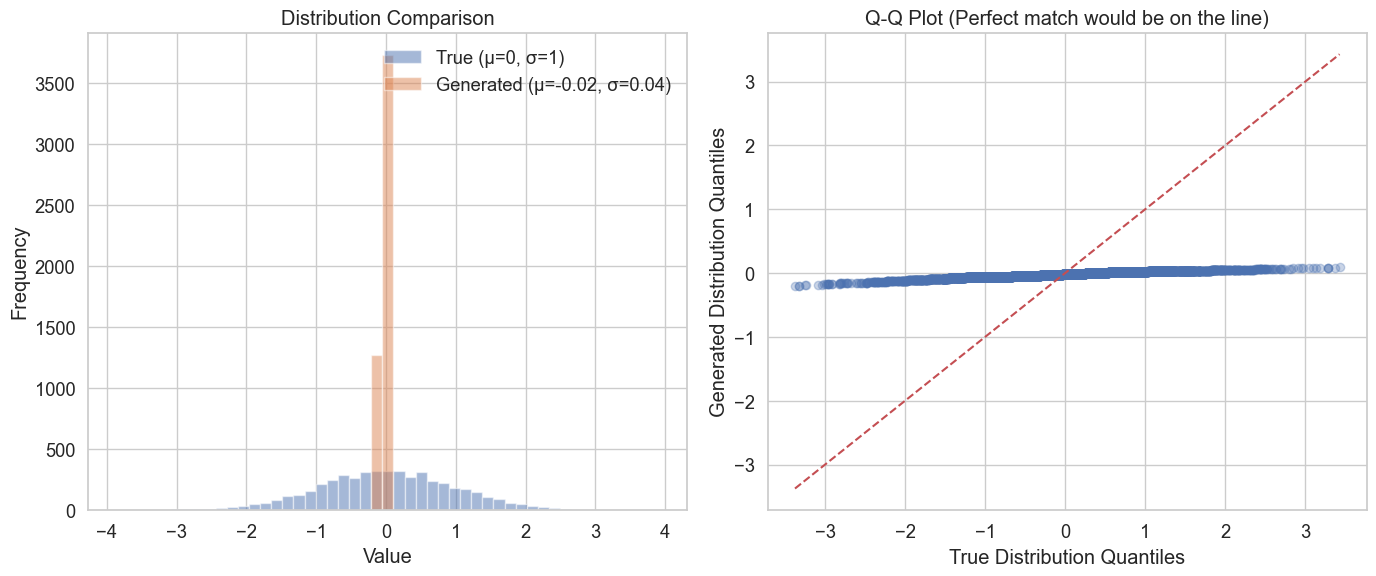

Generated distribution statistics:
  Mean = -0.0219 (Target: 0)
  Std  = 0.0431 (Target: 1)
  Min  = -0.2036
  Max  = 0.0927
  Wasserstein distance = 0.7587 (lower is better)


In [5]:
def visualize_generator_output(generator, noise_dim=z_dim, n_samples=5000):
    """Visualize current generator output compared to target distribution."""
    # Generate samples
    with torch.no_grad():
        z = torch.randn(n_samples, noise_dim).to(device)
        generated = generator(z).cpu().numpy().flatten()

    # Generate true normal distribution samples
    true_samples = np.random.normal(target_mean, target_std, n_samples)

    # Calculate statistics
    gen_mean = generated.mean()
    gen_std = generated.std()

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram comparison
    bins = np.linspace(
        min(generated.min(), true_samples.min()) - 0.5,
        max(generated.max(), true_samples.max()) + 0.5,
        50,
    )

    ax[0].hist(
        true_samples,
        bins=bins,
        alpha=0.5,
        label=f"True (μ={target_mean}, σ={target_std})",
    )
    ax[0].hist(
        generated,
        bins=bins,
        alpha=0.5,
        label=f"Generated (μ={gen_mean:.2f}, σ={gen_std:.2f})",
    )
    ax[0].set_title("Distribution Comparison")
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("Frequency")
    ax[0].legend()

    # QQ plot
    ax[1].scatter(np.sort(true_samples), np.sort(generated), alpha=0.3)
    min_val = min(true_samples.min(), generated.min())
    max_val = max(true_samples.max(), generated.max())
    ax[1].plot([min_val, max_val], [min_val, max_val], "r--")
    ax[1].set_title("Q-Q Plot (Perfect match would be on the line)")
    ax[1].set_xlabel("True Distribution Quantiles")
    ax[1].set_ylabel("Generated Distribution Quantiles")

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Generated distribution statistics:")
    print(f"  Mean = {gen_mean:.4f} (Target: {target_mean})")
    print(f"  Std  = {gen_std:.4f} (Target: {target_std})")
    print(f"  Min  = {generated.min():.4f}")
    print(f"  Max  = {generated.max():.4f}")

    # Calculate Wasserstein distance
    from scipy.stats import wasserstein_distance

    wd = wasserstein_distance(generated, true_samples)
    print(f"  Wasserstein distance = {wd:.4f} (lower is better)")


# Visualize initial generator output (before training)
print("Generator output BEFORE training:")
visualize_generator_output(generator)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dims=[16, 32, 16]):
        """
        Discriminator network that classifies samples as real or fake.

        Args:
            hidden_dims (list): Dimensions of hidden layers
        """
        super(Discriminator, self).__init__()

        # Build layers dynamically based on hidden_dims
        layers = []
        input_dim = 1  # We're classifying scalar values

        # Add hidden layers
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.LeakyReLU(0.2))
            # Optional: Add dropout for regularization
            layers.append(nn.Dropout(0.3))
            input_dim = h_dim

        # Output layer with sigmoid activation for binary classification
        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())

        # Create sequential model
        self.disc = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the discriminator.

        Args:
            x (Tensor): Input samples, shape [batch_size, 1]

        Returns:
            Tensor: Probability that each sample is real, shape [batch_size, 1]
        """
        return self.disc(x)


# Initialize the discriminator
discriminator = Discriminator(hidden_size).to(device)

# Print model architecture
print("Discriminator Architecture:")
print(discriminator)
print(f"Number of parameters: {sum(p.numel() for p in discriminator.parameters())}")

# Analyze a single forward pass with real and fake data
real_test = torch.tensor([[0.1], [0.5], [-0.2], [1.0], [-0.5]]).float()
real_scores = discriminator(real_test)
print(f"\nTest input shape: {real_test.shape}")
print(f"Test output shape: {real_scores.shape}")
print(f"Sample discriminator outputs (untrained):")
for sample, score in zip(real_test.flatten().tolist(), real_scores.flatten().tolist()):
    print(f"  Value: {sample:.4f}, D(x): {score:.4f}")

Discriminator Architecture:
Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=16, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Number of parameters: 1121

Test input shape: torch.Size([5, 1])
Test output shape: torch.Size([5, 1])
Sample discriminator outputs (untrained):
  Value: 0.1000, D(x): 0.5139
  Value: 0.5000, D(x): 0.4815
  Value: -0.2000, D(x): 0.5140
  Value: 1.0000, D(x): 0.4823
  Value: -0.5000, D(x): 0.5163


In [7]:
# Optimizers with beta parameters explained
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Binary Cross Entropy Loss - appropriate for binary classification (real vs fake)
criterion = nn.BCELoss()

# Print optimization setup
print("Optimization Setup:")
print(f"Learning rate: {lr}")
print(f"Adam betas: ({beta1}, {beta2})")
print(f"Loss function: Binary Cross Entropy")

Optimization Setup:
Learning rate: 0.0002
Adam betas: (0.5, 0.999)
Loss function: Binary Cross Entropy


In [8]:
# Lists to store metrics for plotting
g_losses = []  # Generator losses
d_losses = []  # Discriminator losses
mean_list = []  # Mean of generated distribution over time
std_list = []  # Standard deviation of generated distribution over time
w_distances = []  # Wasserstein distances over time


# Function to compute Wasserstein distance
def compute_wasserstein_distance(
    generated_samples, target_mean=0, target_std=1, n_samples=1000
):
    """Compute Wasserstein distance between generated samples and target distribution."""
    from scipy.stats import wasserstein_distance

    true_samples = np.random.normal(target_mean, target_std, n_samples)
    return wasserstein_distance(generated_samples.flatten(), true_samples)


# Create a progress tracking time
start_time = time.time()

In [9]:
# Tracking metrics
metrics = {
    "g_losses": [],  # Generator losses
    "d_losses": [],  # Discriminator losses
    "mean_values": [],  # Generated distribution mean
    "std_values": [],  # Generated distribution std
    "w_distances": [],  # Wasserstein distance
    "d_real_acc": [],  # Discriminator accuracy on real data
    "d_fake_acc": [],  # Discriminator accuracy on fake data
    "epochs": [],  # Epoch markers
}

# Use TQDM for progress tracking
progress_bar = tqdm(range(num_epochs), desc="Training GAN")

# Label smoothing: use 0.9 for real labels instead of 1.0 to prevent overconfidence
real_label_value = 1.0 - label_smoothing
fake_label_value = 0.0

Training GAN:   0%|          | 0/5000 [00:00<?, ?it/s]


Epoch [1/5000]
  D Loss: 1.3889, G Loss: 0.6907
  D Accuracy - Real: 0.0000, Fake: 0.4531
  Generated - Mean: -0.0234, Std: 0.0423, W-dist: 0.7765

Epoch [500/5000]
  D Loss: 1.3497, G Loss: 0.8188
  D Accuracy - Real: 0.0000, Fake: 0.7656
  Generated - Mean: -0.1810, Std: 0.4724, W-dist: 0.4481

Epoch [1000/5000]
  D Loss: 1.3547, G Loss: 0.8688
  D Accuracy - Real: 0.0000, Fake: 0.9941
  Generated - Mean: -0.5802, Std: 1.0073, W-dist: 0.6123


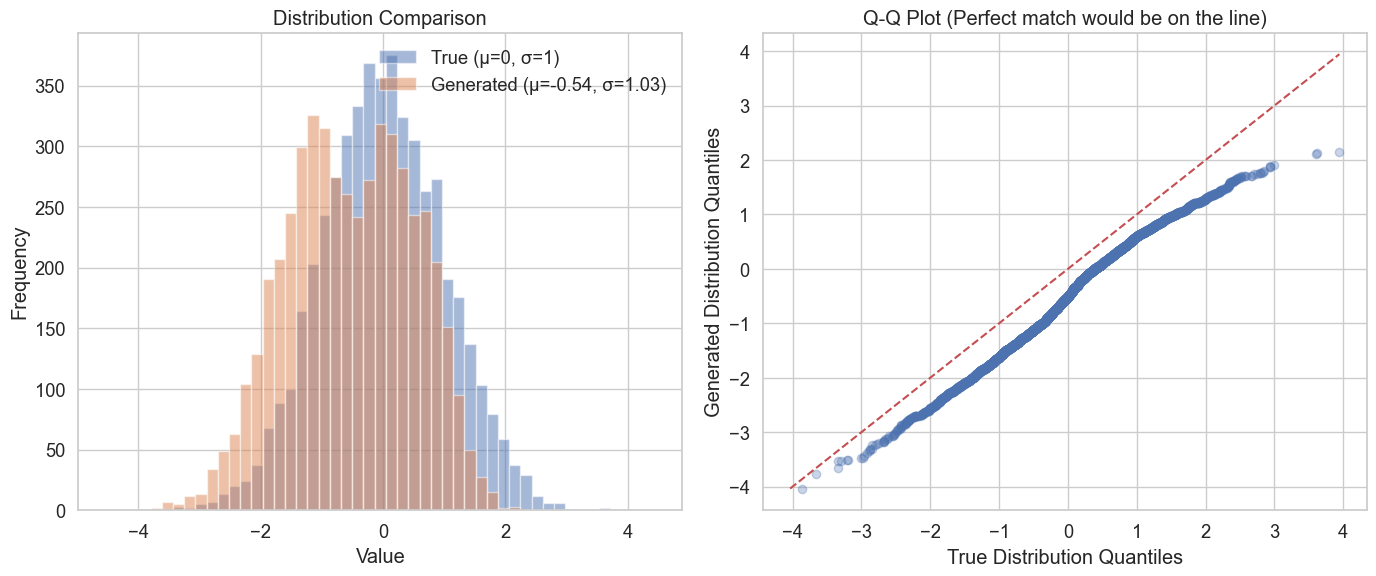

Generated distribution statistics:
  Mean = -0.5356 (Target: 0)
  Std  = 1.0319 (Target: 1)
  Min  = -4.0348
  Max  = 2.1493
  Wasserstein distance = 0.5296 (lower is better)

Epoch [1500/5000]
  D Loss: 1.3805, G Loss: 0.7654
  D Accuracy - Real: 0.0000, Fake: 0.9629
  Generated - Mean: -0.1529, Std: 0.9799, W-dist: 0.1415

Epoch [2000/5000]
  D Loss: 1.3766, G Loss: 0.7744
  D Accuracy - Real: 0.0000, Fake: 0.9941
  Generated - Mean: 0.1807, Std: 0.9176, W-dist: 0.2062


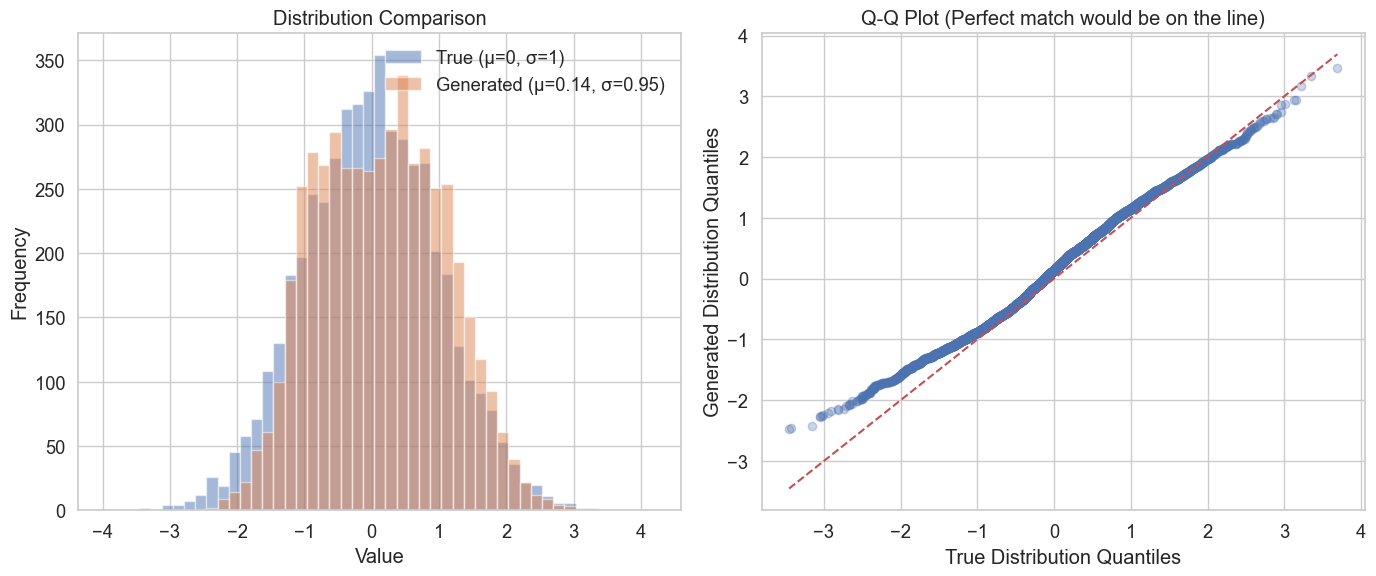

Generated distribution statistics:
  Mean = 0.1364 (Target: 0)
  Std  = 0.9479 (Target: 1)
  Min  = -2.4815
  Max  = 3.4709
  Wasserstein distance = 0.1477 (lower is better)

Epoch [2500/5000]
  D Loss: 1.3755, G Loss: 0.7735
  D Accuracy - Real: 0.0000, Fake: 0.9980
  Generated - Mean: 0.1014, Std: 1.0239, W-dist: 0.1237

Epoch [3000/5000]
  D Loss: 1.3783, G Loss: 0.7814
  D Accuracy - Real: 0.0000, Fake: 1.0000
  Generated - Mean: -0.0729, Std: 1.0392, W-dist: 0.0894


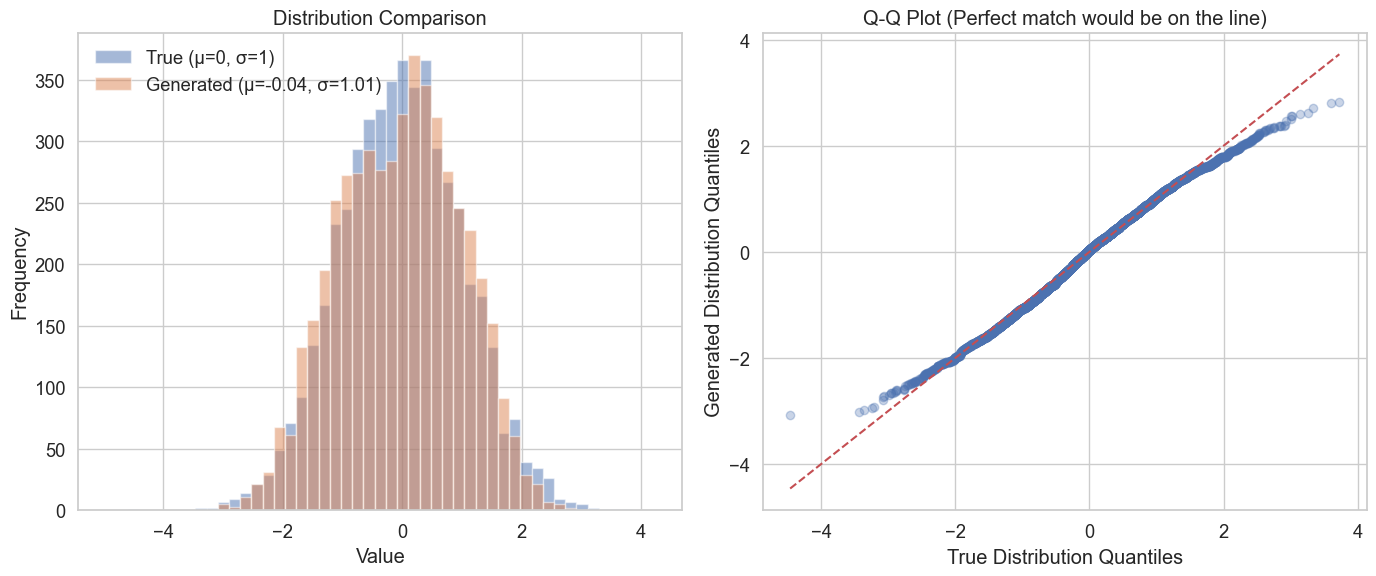

Generated distribution statistics:
  Mean = -0.0422 (Target: 0)
  Std  = 1.0112 (Target: 1)
  Min  = -3.0808
  Max  = 2.8266
  Wasserstein distance = 0.0534 (lower is better)

Epoch [3500/5000]
  D Loss: 1.3762, G Loss: 0.7762
  D Accuracy - Real: 0.0000, Fake: 0.9980
  Generated - Mean: -0.0204, Std: 0.9366, W-dist: 0.0517

Epoch [4000/5000]
  D Loss: 1.3757, G Loss: 0.7738
  D Accuracy - Real: 0.0000, Fake: 1.0000
  Generated - Mean: -0.0127, Std: 0.8989, W-dist: 0.0976


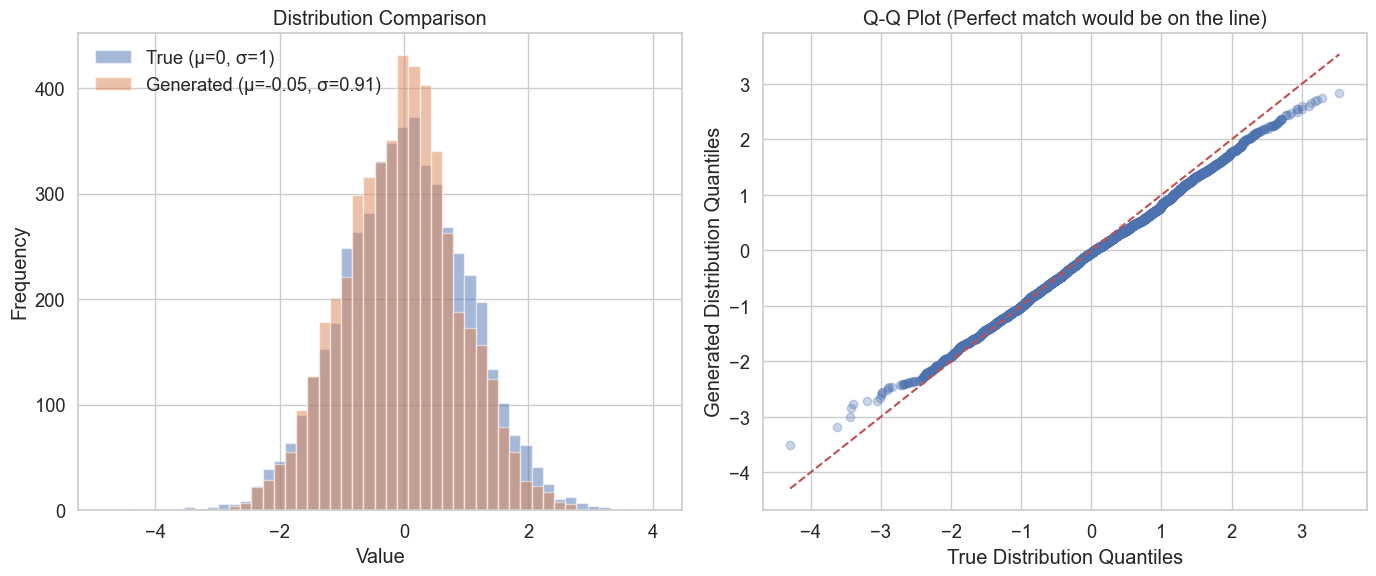

Generated distribution statistics:
  Mean = -0.0497 (Target: 0)
  Std  = 0.9140 (Target: 1)
  Min  = -3.5145
  Max  = 2.8451
  Wasserstein distance = 0.0940 (lower is better)

Epoch [4500/5000]
  D Loss: 1.3767, G Loss: 0.7762
  D Accuracy - Real: 0.0000, Fake: 0.9980
  Generated - Mean: -0.0906, Std: 0.9355, W-dist: 0.1126

Epoch [5000/5000]
  D Loss: 1.3767, G Loss: 0.7759
  D Accuracy - Real: 0.0000, Fake: 0.9980
  Generated - Mean: 0.0806, Std: 0.9214, W-dist: 0.0857


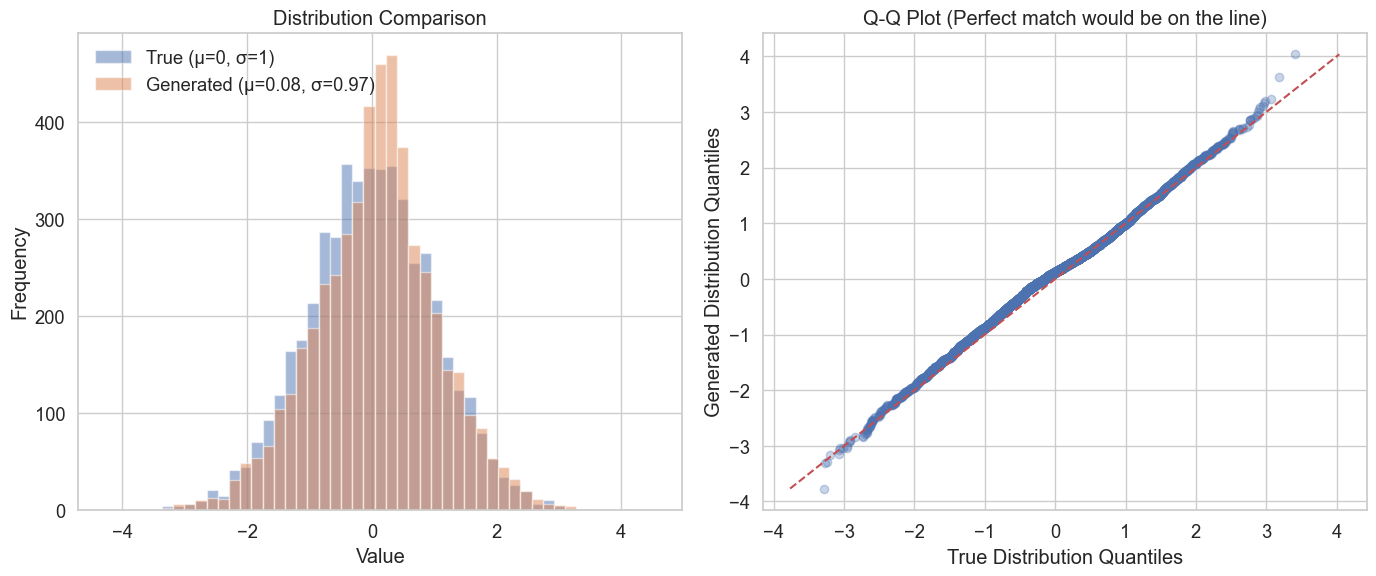

Generated distribution statistics:
  Mean = 0.0751 (Target: 0)
  Std  = 0.9726 (Target: 1)
  Min  = -3.7672
  Max  = 4.0393
  Wasserstein distance = 0.0886 (lower is better)

Training completed in 0.89 minutes

Final Generator Evaluation:


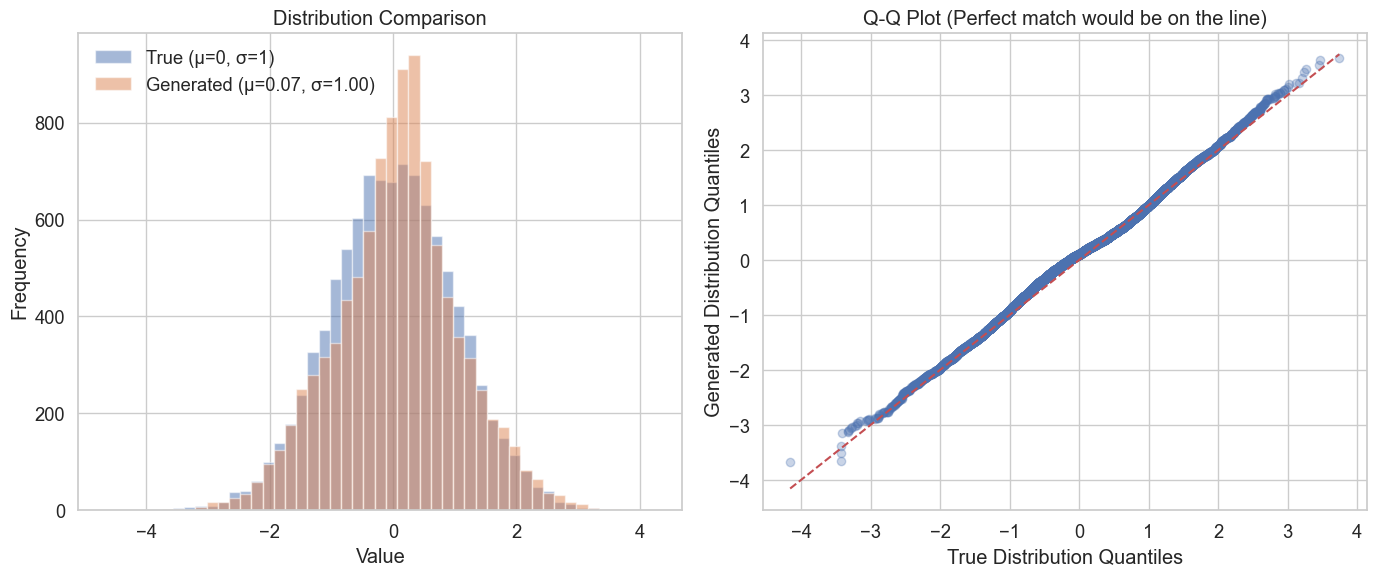

Generated distribution statistics:
  Mean = 0.0738 (Target: 0)
  Std  = 0.9960 (Target: 1)
  Min  = -3.6820
  Max  = 3.6703
  Wasserstein distance = 0.0773 (lower is better)


In [10]:
for epoch in progress_bar:
    # =========================================================================
    # Step 1: Generate Real and Fake Samples
    # =========================================================================

    # Generate real samples from a true normal distribution
    real_samples = torch.randn(batch_size, 1) * target_std + target_mean
    real_samples = real_samples.to(device)

    # Create labels for real samples (with label smoothing)
    real_labels = torch.full((batch_size, 1), real_label_value, device=device)

    # Generate random noise for the generator input
    z = torch.randn(batch_size, z_dim).to(device)

    # Generate fake samples using the generator
    fake_samples = generator(z)

    # Create labels for fake samples
    fake_labels = torch.full((batch_size, 1), fake_label_value, device=device)

    # =========================================================================
    # Step 2: Train the Discriminator
    # =========================================================================

    # Reset discriminator gradients
    d_optimizer.zero_grad()

    # Train with real samples
    d_real_output = discriminator(real_samples)
    d_real_loss = criterion(d_real_output, real_labels)

    # Calculate discriminator accuracy on real samples
    d_real_accuracy = (
        ((d_real_output > 0.5).float() == real_labels).float().mean().item()
    )

    # Train with fake samples
    d_fake_output = discriminator(
        fake_samples.detach()
    )  # detach to avoid updating generator
    d_fake_loss = criterion(d_fake_output, fake_labels)

    # Calculate discriminator accuracy on fake samples
    d_fake_accuracy = (
        ((d_fake_output < 0.5).float() == (1 - fake_labels)).float().mean().item()
    )

    # Combined discriminator loss
    d_loss = d_real_loss + d_fake_loss

    # Backpropagate and optimize
    d_loss.backward()
    d_optimizer.step()

    # =========================================================================
    # Step 3: Train the Generator
    # =========================================================================

    # Reset generator gradients
    g_optimizer.zero_grad()

    # The generator wants the discriminator to classify fake samples as real
    # Note: We recompute the discriminator output on fake samples
    # because we need the gradients to flow to the generator
    d_output_on_fake = discriminator(fake_samples)

    # Generator loss - make discriminator believe fakes are real
    g_loss = criterion(d_output_on_fake, real_labels)

    # Backpropagate and optimize
    g_loss.backward()
    g_optimizer.step()

    # =========================================================================
    # Step 4: Track Progress and Metrics
    # =========================================================================

    # Calculate discriminator overall accuracy
    d_accuracy = (d_real_accuracy + d_fake_accuracy) / 2

    # Update progress bar with current losses
    progress_bar.set_postfix(
        {
            "D Loss": f"{d_loss.item():.4f}",
            "G Loss": f"{g_loss.item():.4f}",
            "D Acc": f"{d_accuracy:.2f}",
        }
    )

    # Record detailed metrics at display intervals
    if (epoch + 1) % display_step == 0 or epoch == 0 or epoch == num_epochs - 1:
        # Generate samples for evaluation
        with torch.no_grad():
            eval_z = torch.randn(1000, z_dim).to(device)
            eval_samples = generator(eval_z).cpu().numpy()

            # Calculate metrics
            curr_mean = eval_samples.mean()
            curr_std = eval_samples.std()
            w_dist = compute_wasserstein_distance(eval_samples, target_mean, target_std)

            # Store metrics
            metrics["epochs"].append(epoch + 1)
            metrics["g_losses"].append(g_loss.item())
            metrics["d_losses"].append(d_loss.item())
            metrics["mean_values"].append(curr_mean)
            metrics["std_values"].append(curr_std)
            metrics["w_distances"].append(w_dist)
            metrics["d_real_acc"].append(d_real_accuracy)
            metrics["d_fake_acc"].append(d_fake_accuracy)

            # Display metrics
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            print(f"  D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            print(
                f"  D Accuracy - Real: {d_real_accuracy:.4f}, Fake: {d_fake_accuracy:.4f}"
            )
            print(
                f"  Generated - Mean: {curr_mean:.4f}, Std: {curr_std:.4f}, W-dist: {w_dist:.4f}"
            )

            # Visualize generator progress
            if (epoch + 1) % (display_step * 2) == 0:
                visualize_generator_output(generator)

# Display final results
print(f"\nTraining completed in {(time.time() - start_time)/60:.2f} minutes")

# Final evaluation
print("\nFinal Generator Evaluation:")
visualize_generator_output(generator, n_samples=10000)

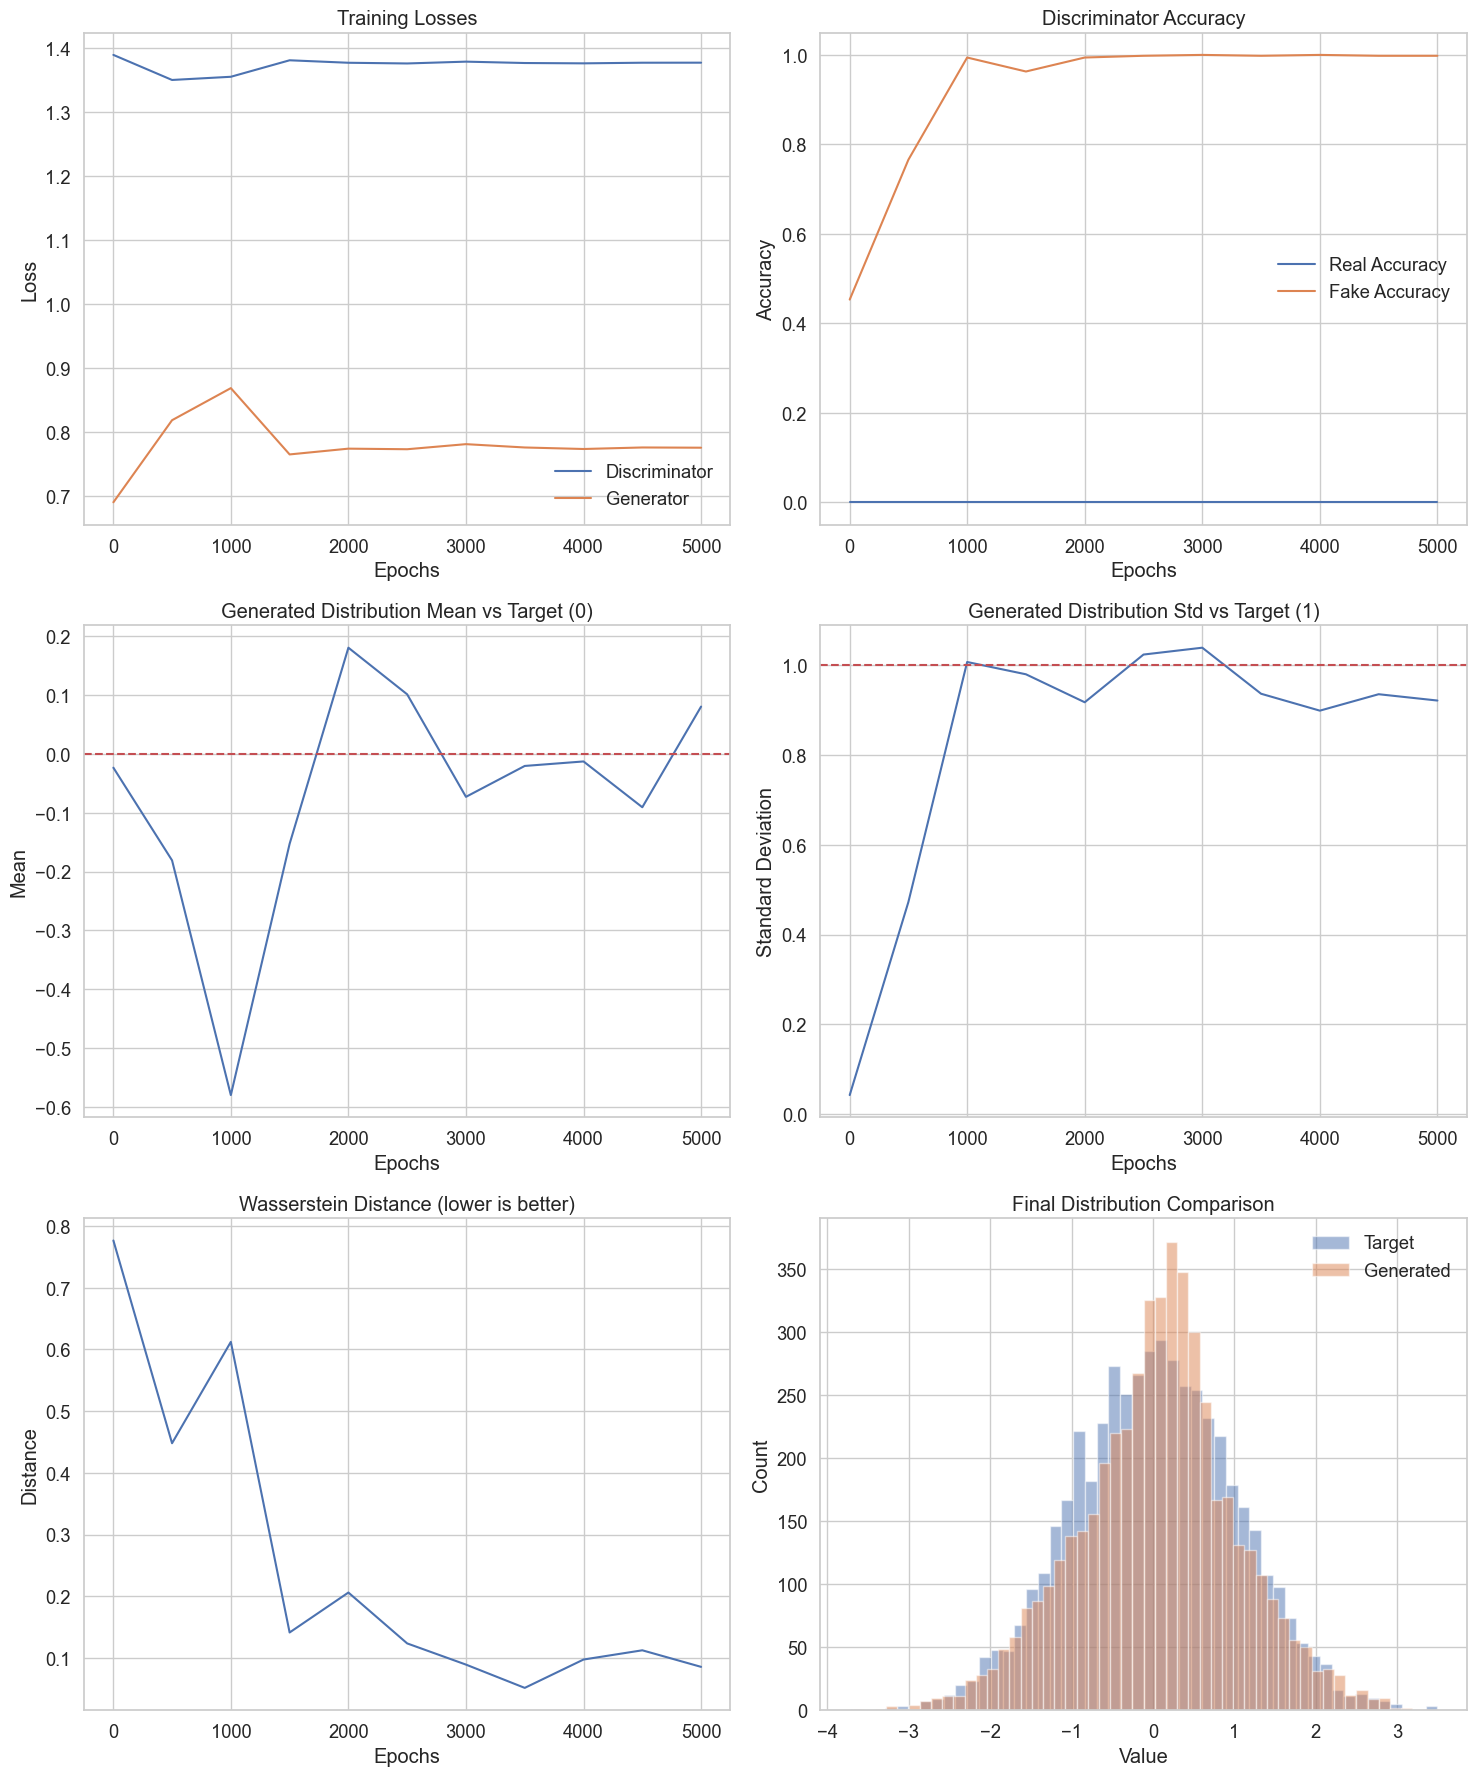

In [11]:
# Function to visualize training progress
def visualize_training_progress(metrics):
    """Visualize multiple training metrics in a single plot."""
    epochs = metrics["epochs"]

    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    # Plot losses
    axes[0, 0].plot(epochs, metrics["d_losses"], label="Discriminator")
    axes[0, 0].plot(epochs, metrics["g_losses"], label="Generator")
    axes[0, 0].set_title("Training Losses")
    axes[0, 0].set_xlabel("Epochs")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].legend()

    # Plot discriminator accuracy
    axes[0, 1].plot(epochs, metrics["d_real_acc"], label="Real Accuracy")
    axes[0, 1].plot(epochs, metrics["d_fake_acc"], label="Fake Accuracy")
    axes[0, 1].set_title("Discriminator Accuracy")
    axes[0, 1].set_xlabel("Epochs")
    axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].legend()

    # Plot distribution mean
    axes[1, 0].plot(epochs, metrics["mean_values"])
    axes[1, 0].axhline(y=target_mean, color="r", linestyle="--")
    axes[1, 0].set_title(f"Generated Distribution Mean vs Target ({target_mean})")
    axes[1, 0].set_xlabel("Epochs")
    axes[1, 0].set_ylabel("Mean")

    # Plot distribution std
    axes[1, 1].plot(epochs, metrics["std_values"])
    axes[1, 1].axhline(y=target_std, color="r", linestyle="--")
    axes[1, 1].set_title(f"Generated Distribution Std vs Target ({target_std})")
    axes[1, 1].set_xlabel("Epochs")
    axes[1, 1].set_ylabel("Standard Deviation")

    # Plot Wasserstein distance
    axes[2, 0].plot(epochs, metrics["w_distances"])
    axes[2, 0].set_title("Wasserstein Distance (lower is better)")
    axes[2, 0].set_xlabel("Epochs")
    axes[2, 0].set_ylabel("Distance")

    # Plot final distribution comparison
    with torch.no_grad():
        z = torch.randn(5000, z_dim).to(device)
        gen_samples = generator(z).cpu().numpy().flatten()

    axes[2, 1].hist(
        np.random.normal(target_mean, target_std, 5000),
        bins=50,
        alpha=0.5,
        label="Target",
    )
    axes[2, 1].hist(gen_samples, bins=50, alpha=0.5, label="Generated")
    axes[2, 1].set_title("Final Distribution Comparison")
    axes[2, 1].set_xlabel("Value")
    axes[2, 1].set_ylabel("Count")
    axes[2, 1].legend()

    plt.tight_layout()
    plt.savefig("gan_training_progress.png")
    plt.show()


# Visualize all training metrics
visualize_training_progress(metrics)

In [12]:
# Generate a large number of samples for thorough analysis
with torch.no_grad():
    n_evaluation_samples = 50000
    z = torch.randn(n_evaluation_samples, z_dim).to(device)
    generated_samples = generator(z).cpu().numpy().flatten()

# Generate real samples for comparison
real_samples = np.random.normal(target_mean, target_std, n_evaluation_samples)

print(f"Generated {n_evaluation_samples} samples for evaluation")

Generated 50000 samples for evaluation


In [13]:
from scipy import stats


def calculate_distribution_statistics(samples, distribution_name):
    """Calculate and print comprehensive statistics for a distribution."""
    mean = samples.mean()
    median = np.median(samples)
    std = samples.std()
    skewness = stats.skew(samples)
    kurtosis = stats.kurtosis(samples)
    min_val = samples.min()
    max_val = samples.max()

    # Calculate percentiles
    p5, p25, p75, p95 = np.percentile(samples, [5, 25, 75, 95])

    print(f"\n{distribution_name} Distribution Statistics:")
    print(f"  Mean: {mean:.6f}")
    print(f"  Median: {median:.6f}")
    print(f"  Standard Deviation: {std:.6f}")
    print(f"  Skewness: {skewness:.6f} (0 for perfect normal)")
    print(f"  Kurtosis: {kurtosis:.6f} (0 for perfect normal)")
    print(f"  Range: [{min_val:.6f}, {max_val:.6f}]")
    print(f"  Percentiles:")
    print(f"    5th: {p5:.6f}")
    print(f"    25th: {p25:.6f}")
    print(f"    75th: {p75:.6f}")
    print(f"    95th: {p95:.6f}")

    return {
        "mean": mean,
        "median": median,
        "std": std,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "min": min_val,
        "max": max_val,
        "p5": p5,
        "p25": p25,
        "p75": p75,
        "p95": p95,
    }


# Calculate statistics for both distributions
gen_stats = calculate_distribution_statistics(generated_samples, "Generated")
real_stats = calculate_distribution_statistics(real_samples, "Real (Target)")

# Calculate statistical tests to compare distributions
ks_stat, ks_pvalue = stats.ks_2samp(generated_samples, real_samples)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Statistic: {ks_stat:.6f}")
print(f"  p-value: {ks_pvalue:.6f}")
print(
    f"  Interpretation: {'Distributions are similar (fail to reject H0)' if ks_pvalue > 0.05 else 'Distributions are different (reject H0)'}"
)

# Wasserstein distance
w_distance = stats.wasserstein_distance(generated_samples, real_samples)
print(f"\nWasserstein Distance: {w_distance:.6f}")


Generated Distribution Statistics:
  Mean: 0.066377
  Median: 0.118733
  Standard Deviation: 0.979200
  Skewness: -0.080337 (0 for perfect normal)
  Kurtosis: 0.284213 (0 for perfect normal)
  Range: [-4.117547, 4.314221]
  Percentiles:
    5th: -1.620888
    25th: -0.532779
    75th: 0.644705
    95th: 1.693563

Real (Target) Distribution Statistics:
  Mean: 0.002492
  Median: 0.003151
  Standard Deviation: 0.998436
  Skewness: 0.008038 (0 for perfect normal)
  Kurtosis: 0.003165 (0 for perfect normal)
  Range: [-4.462969, 4.202026]
  Percentiles:
    5th: -1.642511
    25th: -0.665391
    75th: 0.672753
    95th: 1.649649

Kolmogorov-Smirnov Test:
  Statistic: 0.058040
  p-value: 0.000000
  Interpretation: Distributions are different (reject H0)

Wasserstein Distance: 0.071658


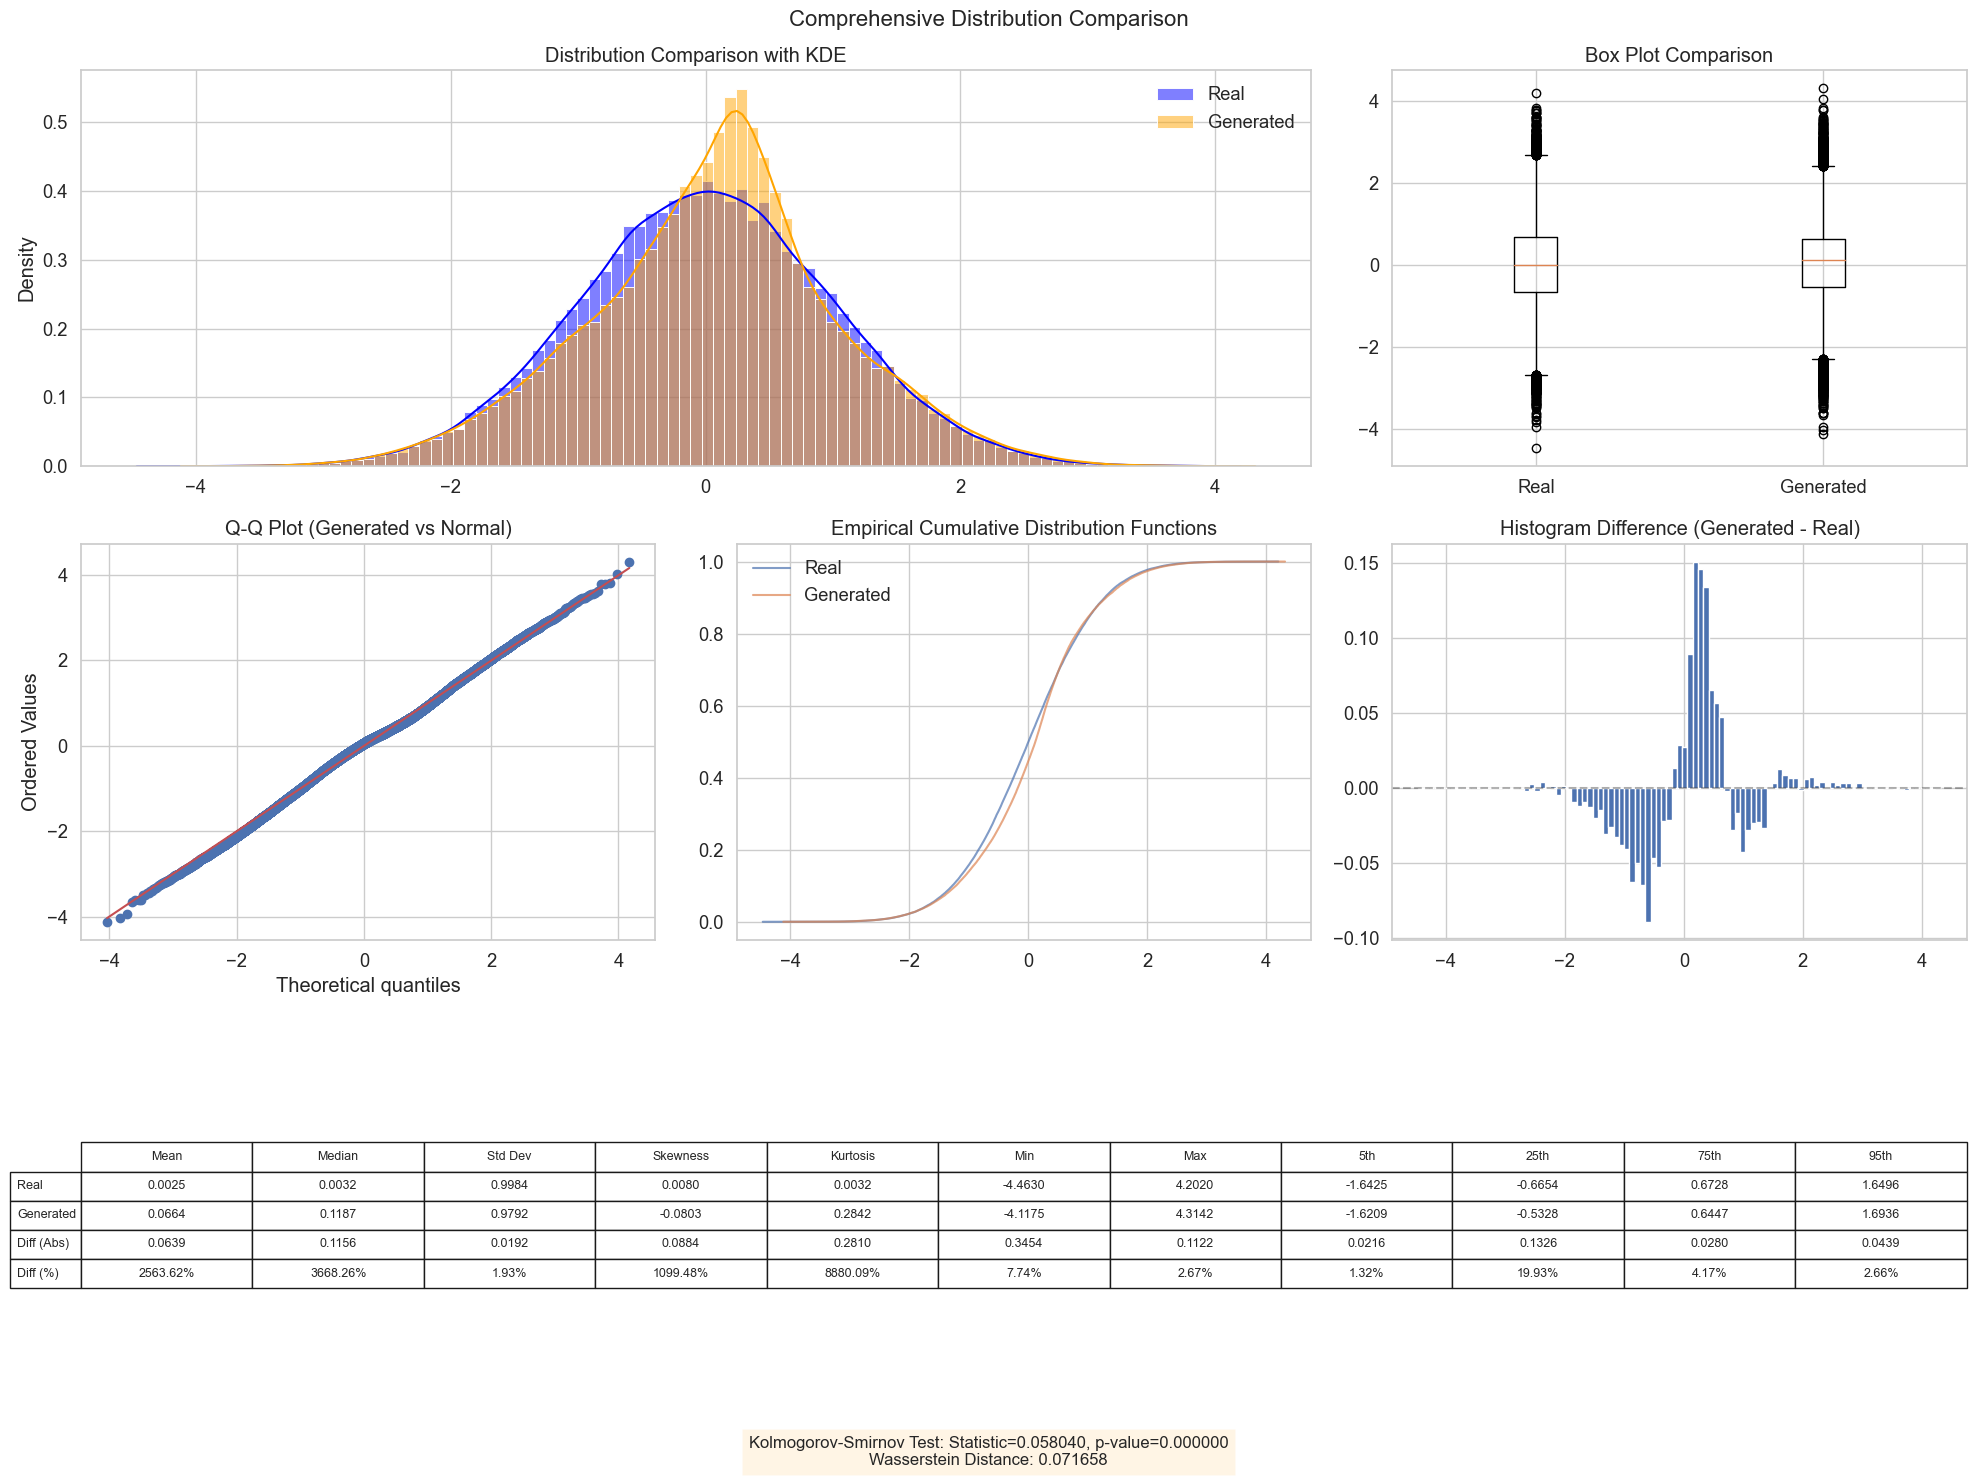

In [14]:
def comprehensive_visual_evaluation(generated, real, gen_stats, real_stats):
    """Create comprehensive visualization comparing distributions."""
    fig = plt.figure(figsize=(20, 15))

    # Define common bins for consistent comparison
    all_samples = np.concatenate([generated, real])
    min_val, max_val = all_samples.min(), all_samples.max()
    bins = np.linspace(min_val, max_val, 100)

    # 1. Histograms with KDE
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    sns.histplot(
        real,
        bins=bins,
        kde=True,
        stat="density",
        label="Real",
        color="blue",
        alpha=0.5,
        ax=ax1,
    )
    sns.histplot(
        generated,
        bins=bins,
        kde=True,
        stat="density",
        label="Generated",
        color="orange",
        alpha=0.5,
        ax=ax1,
    )
    ax1.set_title("Distribution Comparison with KDE")
    ax1.legend()

    # 2. Box plots
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    box_data = [real, generated]
    ax2.boxplot(box_data, labels=["Real", "Generated"])
    ax2.set_title("Box Plot Comparison")

    # 3. QQ plot
    ax3 = plt.subplot2grid((3, 3), (1, 0))
    qqplot = stats.probplot(
        generated, dist="norm", sparams=(gen_stats["mean"], gen_stats["std"]), plot=ax3
    )
    ax3.set_title("Q-Q Plot (Generated vs Normal)")

    # 4. ECDFs
    ax4 = plt.subplot2grid((3, 3), (1, 1))
    x_real = np.sort(real)
    y_real = np.arange(1, len(x_real) + 1) / len(x_real)
    x_gen = np.sort(generated)
    y_gen = np.arange(1, len(x_gen) + 1) / len(x_gen)
    ax4.plot(x_real, y_real, label="Real", alpha=0.7)
    ax4.plot(x_gen, y_gen, label="Generated", alpha=0.7)
    ax4.set_title("Empirical Cumulative Distribution Functions")
    ax4.legend()

    # 5. Difference in histograms
    ax5 = plt.subplot2grid((3, 3), (1, 2))
    hist_real, _ = np.histogram(real, bins=bins, density=True)
    hist_gen, _ = np.histogram(generated, bins=bins, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax5.bar(bin_centers, hist_gen - hist_real, width=bin_centers[1] - bin_centers[0])
    ax5.set_title("Histogram Difference (Generated - Real)")
    ax5.axhline(0, color="black", linestyle="--", alpha=0.3)

    # 6. Statistical comparison table
    ax6 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    ax6.axis("tight")
    ax6.axis("off")

    # Create table data
    col_labels = [
        "Mean",
        "Median",
        "Std Dev",
        "Skewness",
        "Kurtosis",
        "Min",
        "Max",
        "5th",
        "25th",
        "75th",
        "95th",
    ]
    row_labels = ["Real", "Generated", "Diff (Abs)", "Diff (%)"]

    # Row 1 - Real data
    row1 = [
        real_stats[key]
        for key in [
            "mean",
            "median",
            "std",
            "skewness",
            "kurtosis",
            "min",
            "max",
            "p5",
            "p25",
            "p75",
            "p95",
        ]
    ]

    # Row 2 - Generated data
    row2 = [
        gen_stats[key]
        for key in [
            "mean",
            "median",
            "std",
            "skewness",
            "kurtosis",
            "min",
            "max",
            "p5",
            "p25",
            "p75",
            "p95",
        ]
    ]

    # Row 3 - Absolute difference
    row3 = [abs(r - g) for r, g in zip(row1, row2)]

    # Row 4 - Percentage difference (with safe division)
    row4 = [abs(r - g) / (abs(r) + 1e-10) * 100 for r, g in zip(row1, row2)]

    # Format values for display
    def format_row(row):
        return [f"{x:.4f}" for x in row]

    table_data = [
        format_row(row1),
        format_row(row2),
        format_row(row3),
        [f"{x:.2f}%" for x in row4],
    ]

    table = ax6.table(
        cellText=table_data,
        rowLabels=row_labels,
        colLabels=col_labels,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)

    # Add KS test and Wasserstein distance as text
    txt = (
        f"Kolmogorov-Smirnov Test: Statistic={ks_stat:.6f}, p-value={ks_pvalue:.6f}\n"
        f"Wasserstein Distance: {w_distance:.6f}"
    )
    plt.figtext(
        0.5,
        0.01,
        txt,
        ha="center",
        fontsize=12,
        bbox={"facecolor": "orange", "alpha": 0.1, "pad": 5},
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.suptitle("Comprehensive Distribution Comparison", fontsize=16)
    plt.savefig("gan_distribution_evaluation.png", dpi=300, bbox_inches="tight")
    plt.show()


# Run comprehensive visual evaluation
comprehensive_visual_evaluation(generated_samples, real_samples, gen_stats, real_stats)